In [1]:
#!pip3 install seaborn

In [2]:
import json
import matplotlib.pyplot as plt
import os
import pandas as pd
import seaborn as sns
from typing import List

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
SEEDS = [0, 42, 1001]
DROP_APPROACHES = ['RBF']

In [5]:
def get_df_for_dataset(database_name: str, dataset_name: str) -> pd.DataFrame:
    def get_df_for_dataset_inner(database_name: str, dataset_name: str, seed: int) -> pd.DataFrame:
        metrics_df = pd.DataFrame()
        directory_path = f"outputs/outputs_linux/seed_{seed}/report/{database_name}/{dataset_name}"
        
        for root, dirs, files in os.walk(directory_path):
            for filename in files:
                if filename.endswith('.json'):
                    file_path = os.path.join(root, filename)
                    
                    with open(file_path, 'r') as file:
                        data = json.load(file)
                        metrics_df = pd.concat([metrics_df,
                                                pd.DataFrame({
                                                    'cut_point_model': [data['cut_point_model']],
                                                    'cut_point_method': [data['cut_point_method']],
                                                    'cut_point_approach': [data['cut_point_approach']],
                                                    'cut_point_perc': [data['cut_point_perc']],
                                                    'cut_duration': [data['cut_duration']],
                                                    'tuner_duration': [data['tuner_duration']],
                                                    'total_duration': [data['total_duration']],
                                                    'Avg_MAPE': [data['error_results']['Avg_MAPE']],
                                                    'Avg_MAE': [data['error_results']['Avg_MAE']], 
                                                    'Avg_MSE': [data['error_results']['Avg_MSE']], 
                                                    'Avg_R2':  [data['error_results']['Avg_R2']],
                                                })])
        metrics_df['cut_point_approach'] = metrics_df['cut_point_approach'].str.replace('Rbf', 'RBF')
        metrics_df['cut_point_approach'] = metrics_df['cut_point_approach'].str.replace(' Ar', ' AR')
        metrics_df['cut_point_approach'] = metrics_df['cut_point_approach'].str.replace('Bin_Seg', 'BinSeg')
        metrics_df['cut_point_approach'] = metrics_df['cut_point_approach'].str.replace('Bottom_Up', 'BottomUp')
        metrics_df['cut_point_approach'] = metrics_df['cut_point_approach'].str.replace('Fixed_Perc Fixed_Cut_0.0', 'Full')
        metrics_df['cut_point_approach'] = metrics_df['cut_point_approach'].str.replace('Fixed_Perc Fixed_Cut_', 'Fixed Cut ')
        metrics_df['cut_point_approach'] = metrics_df['cut_point_approach'].str.replace('0.1', '10%')
        metrics_df['cut_point_approach'] = metrics_df['cut_point_approach'].str.replace('0.2', '20%')
        metrics_df['cut_point_approach'] = metrics_df['cut_point_approach'].str.replace('0.3', '30%')
        metrics_df['cut_point_approach'] = metrics_df['cut_point_approach'].str.replace('0.4', '40%')
        metrics_df['cut_point_approach'] = metrics_df['cut_point_approach'].str.replace('0.5', '50%')
        metrics_df['cut_point_approach'] = metrics_df['cut_point_approach'].str.replace('0.6', '60%')
        metrics_df['cut_point_approach'] = metrics_df['cut_point_approach'].str.replace('0.7', '70%')
        metrics_df['cut_point_approach'] = metrics_df['cut_point_approach'].str.replace('0.8', '80%')

        metrics_df = metrics_df[~metrics_df['cut_point_approach'].str.endswith(tuple(DROP_APPROACHES))]

        return metrics_df

    metrics_dfs = []

    for seed in SEEDS:
        metrics_dfs.append(get_df_for_dataset_inner(
            database_name, dataset_name, seed
        ))

    metrics_df = pd.concat(metrics_dfs)

    group_cols = ['cut_point_model', 'cut_point_method', 'cut_point_approach']
    value_cols = metrics_df.columns.difference(group_cols)

    for value_col in value_cols:
        metrics_df[value_col] = metrics_df[value_col].astype('float')
    
    metrics_df = metrics_df.groupby(group_cols)
    
    metrics_mean = metrics_df[value_cols].mean()
    metrics_std = metrics_df[value_cols].std()
    
    metrics_df = pd.merge(metrics_mean, metrics_std, on=group_cols, suffixes=('_mean', '_std'))

    return metrics_df

In [6]:
def plot_metrics(
        df: pd.DataFrame,
        x_col: str,
        y_col: str,
        x_label: str = None,
        y_label: str = None,
        dataset_name: str = None,
        ascending: bool = True,
        show_title: bool = True,
        pdf_filename: str = None,
    ) -> None:
    if not x_col.endswith('_mean'):
        x_col = f"{x_col}_mean"    
    std_col = x_col.replace('_mean', '_std')
    
    df = df.sort_values(by=x_col, ascending=ascending)

    plt.figure(figsize=(12, 8))
    p = sns.barplot(x=x_col, y=y_col, data=df, palette='viridis')
    p.errorbar(
        y=range(len(df)),
        x=df[x_col],
        xerr=df[std_col],
        fmt='none',
        linewidth=1,
        c='black'
    )

    for index, value in enumerate(df[x_col]):
        p.text(value, index, f'{value:.2f}', color='black', va='center_baseline')

    title = f"Comparison of {y_col} by {x_col}"
    if dataset_name:
        title = f"[{dataset_name}] {title}"

    if show_title:
        plt.title(title)
    
    x_label = x_col if x_label is None else x_label
    y_label = y_col if y_label is None else y_label
    
    plt.xlabel(x_label)
    plt.ylabel(y_label)

    if pdf_filename:
        plt.savefig(f"plots/{pdf_filename}", format='pdf')
        print(f'Saved plot to plots/{pdf_filename}')
    
    plt.show()

In [7]:
datasets = []

# [INMET] BRASILIA_DF

In [8]:
inmet_brasilia_df = get_df_for_dataset('INMET', 'BRASILIA_DF')
inmet_brasilia_df_name = 'INMET BRASILIA_DF'
datasets.append((inmet_brasilia_df, inmet_brasilia_df_name))

Saved plot to plots/inmet_brasilia_mae.pdf


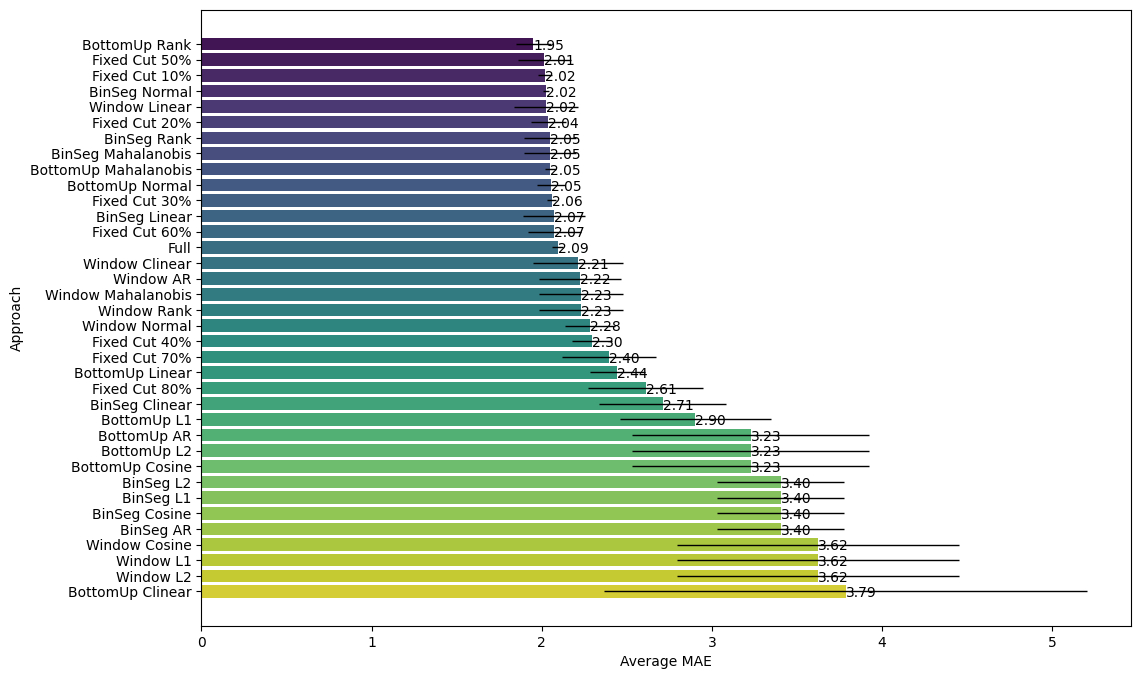

In [9]:
plot_metrics(
    inmet_brasilia_df, 'Avg_MAE', 'cut_point_approach',
    x_label='Average MAE',
    y_label='Approach',
    dataset_name=inmet_brasilia_df_name,
    show_title=False,
    pdf_filename='inmet_brasilia_mae.pdf'
)

Saved plot to plots/inmet_brasilia_mse.pdf


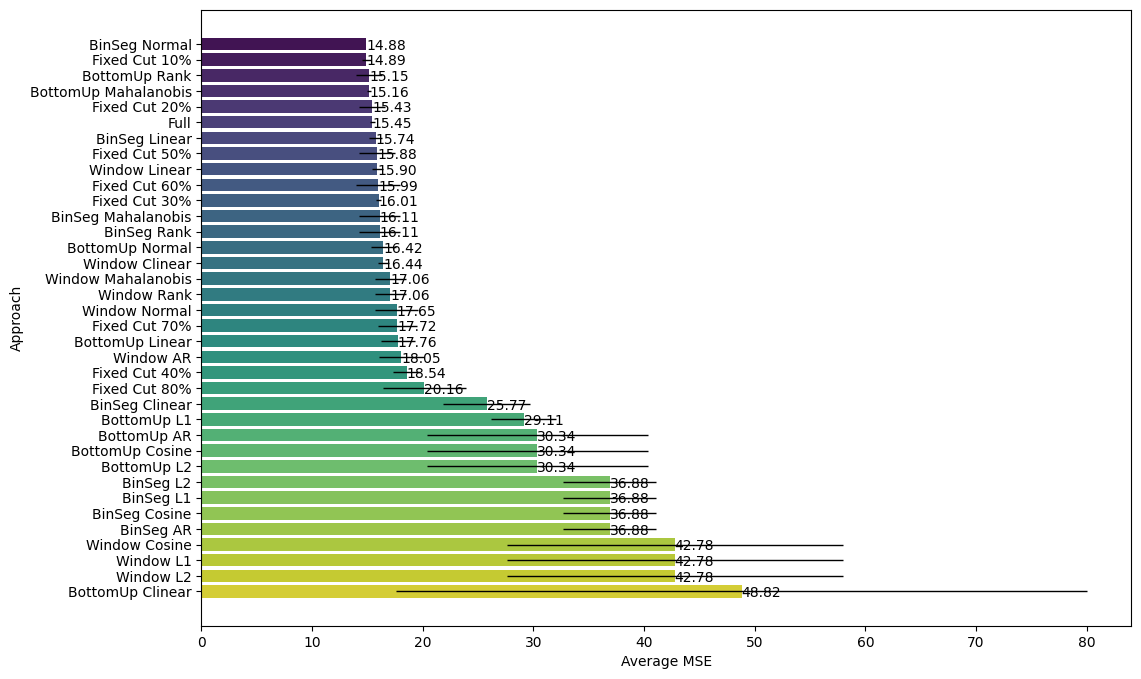

In [10]:
plot_metrics(
    inmet_brasilia_df, 'Avg_MSE', 'cut_point_approach',
    x_label='Average MSE',
    y_label='Approach',
    dataset_name=inmet_brasilia_df_name,
    show_title=False,
    pdf_filename='inmet_brasilia_mse.pdf'
)

Saved plot to plots/inmet_brasilia_tduration.pdf


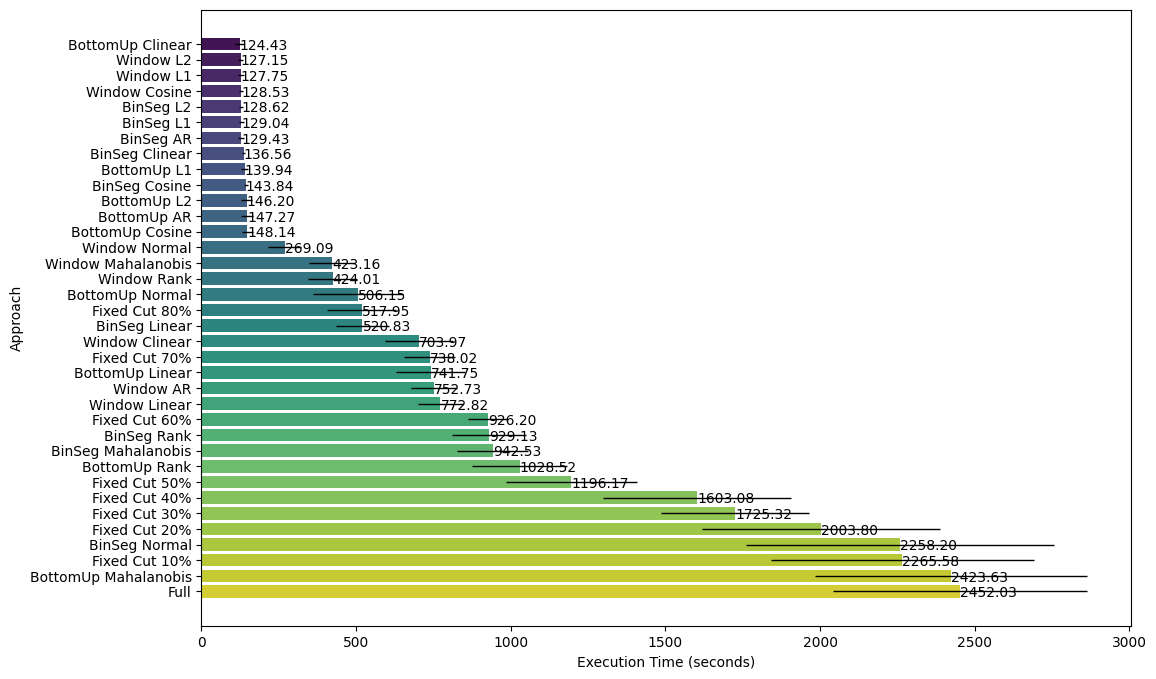

In [11]:
plot_metrics(
    inmet_brasilia_df, 'total_duration', 'cut_point_approach',
    x_label='Execution Time (seconds)',
    y_label='Approach',
    dataset_name=inmet_brasilia_df_name,
    show_title=False,
    pdf_filename='inmet_brasilia_tduration.pdf'
)

# [INMET] CRISTALINA_GO

In [12]:
inmet_cristalina_go = get_df_for_dataset('INMET', 'CRISTALINA_GO')
inmet_cristalina_go_name = 'INMET CRISTALINA_GO'
datasets.append((inmet_cristalina_go, inmet_cristalina_go_name))

Saved plot to plots/inmet_cristalina_mae.pdf


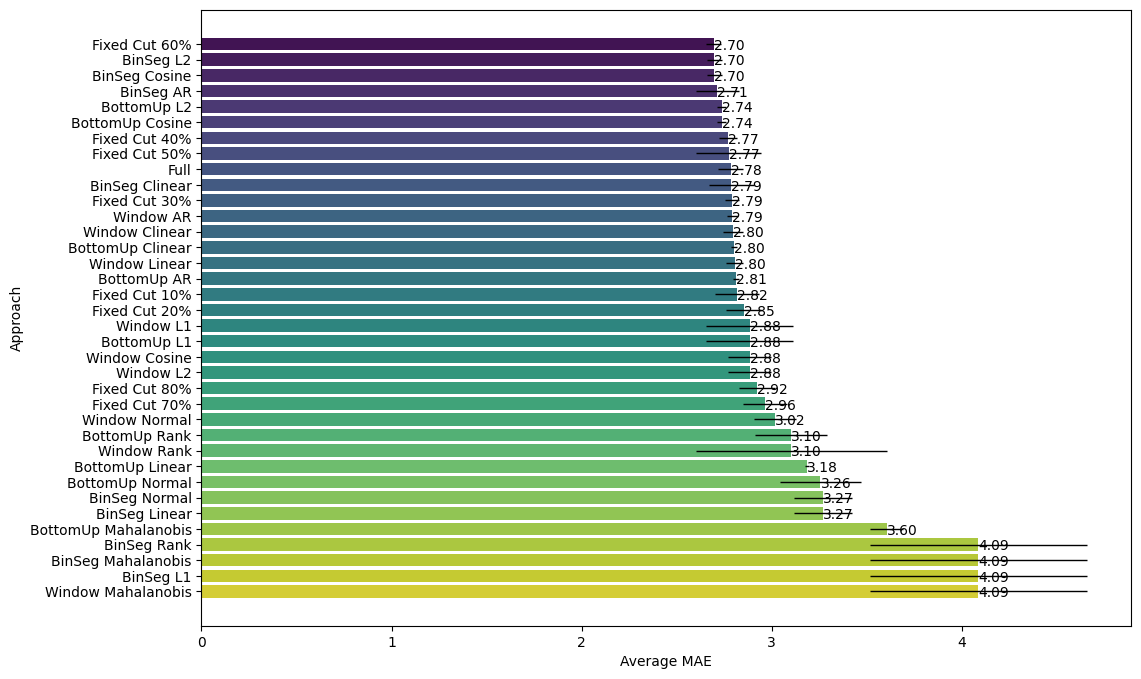

In [13]:
plot_metrics(
    inmet_cristalina_go, 'Avg_MAE', 'cut_point_approach',
    x_label='Average MAE',
    y_label='Approach',
    dataset_name=inmet_cristalina_go_name,
    show_title=False,
    pdf_filename='inmet_cristalina_mae.pdf'
)

Saved plot to plots/inmet_cristalina_mse.pdf


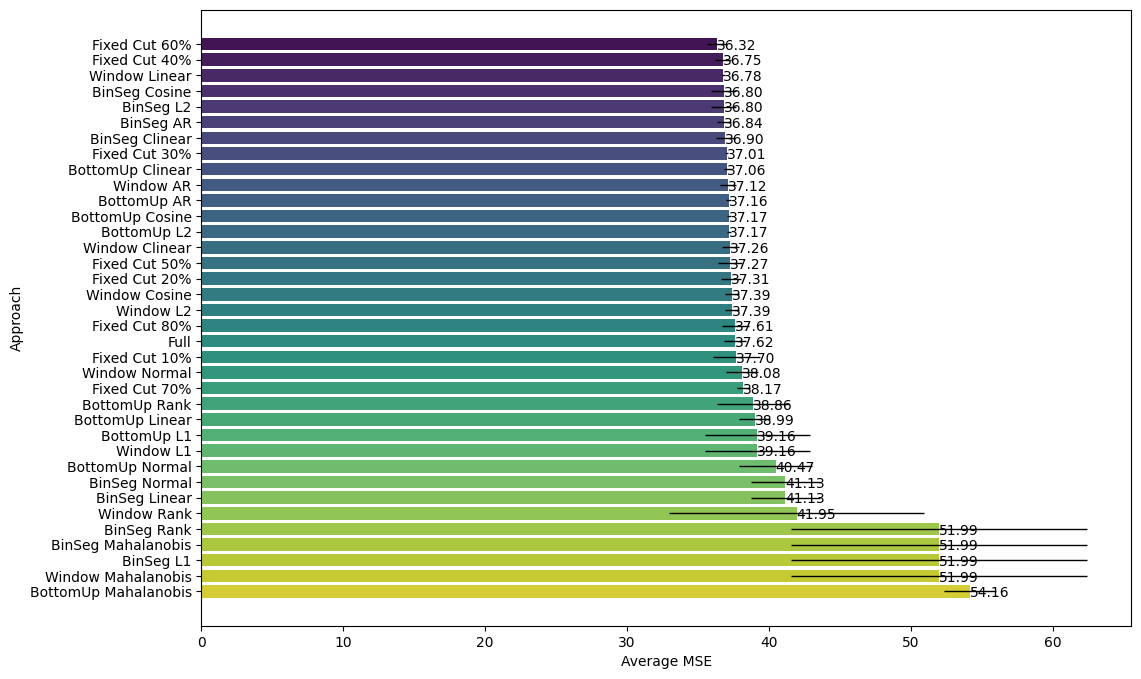

In [14]:
plot_metrics(
    inmet_cristalina_go, 'Avg_MSE', 'cut_point_approach',
    x_label='Average MSE',
    y_label='Approach',
    dataset_name=inmet_cristalina_go_name,
    show_title=False,
    pdf_filename='inmet_cristalina_mse.pdf'
)

Saved plot to plots/inmet_cristalina_tduration.pdf


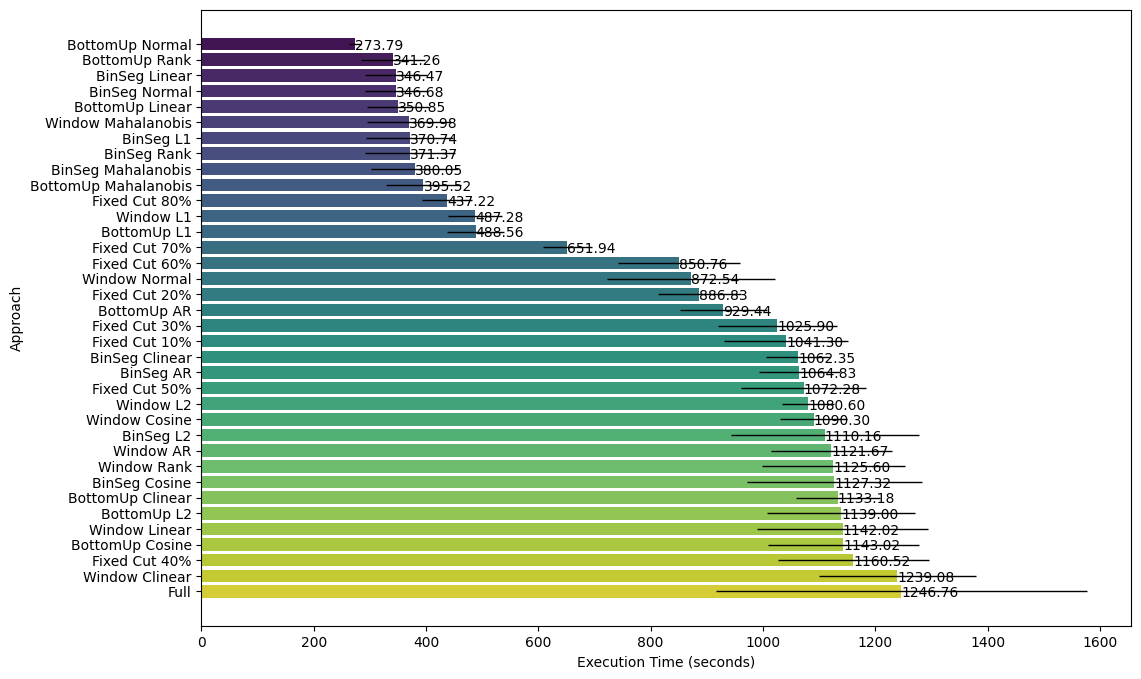

In [15]:
plot_metrics(
    inmet_cristalina_go, 'total_duration', 'cut_point_approach',
    x_label='Execution Time (seconds)',
    y_label='Approach',
    dataset_name=inmet_cristalina_go_name,
    show_title=False,
    pdf_filename='inmet_cristalina_tduration.pdf'
)

# [INMET] IBIRITE_MG

In [16]:
inmet_ibirite_mg = get_df_for_dataset('INMET', 'IBIRITE_MG')
inmet_ibirite_mg_name = 'INMET IBIRITE_MG'
datasets.append((inmet_ibirite_mg, inmet_ibirite_mg_name))

Saved plot to plots/inmet_ibirite_mae.pdf


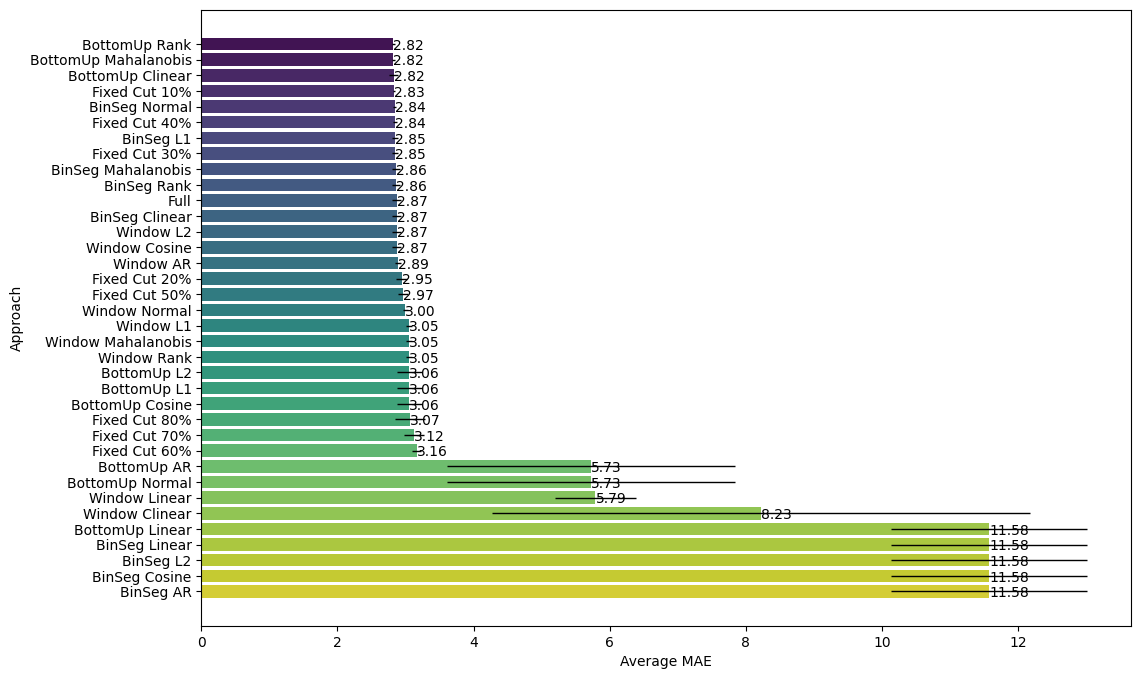

In [17]:
plot_metrics(
    inmet_ibirite_mg, 'Avg_MAE', 'cut_point_approach',
    x_label='Average MAE',
    y_label='Approach',
    dataset_name=inmet_ibirite_mg_name,
    show_title=False,
    pdf_filename='inmet_ibirite_mae.pdf'
)

Saved plot to plots/inmet_ibirite_mse.pdf


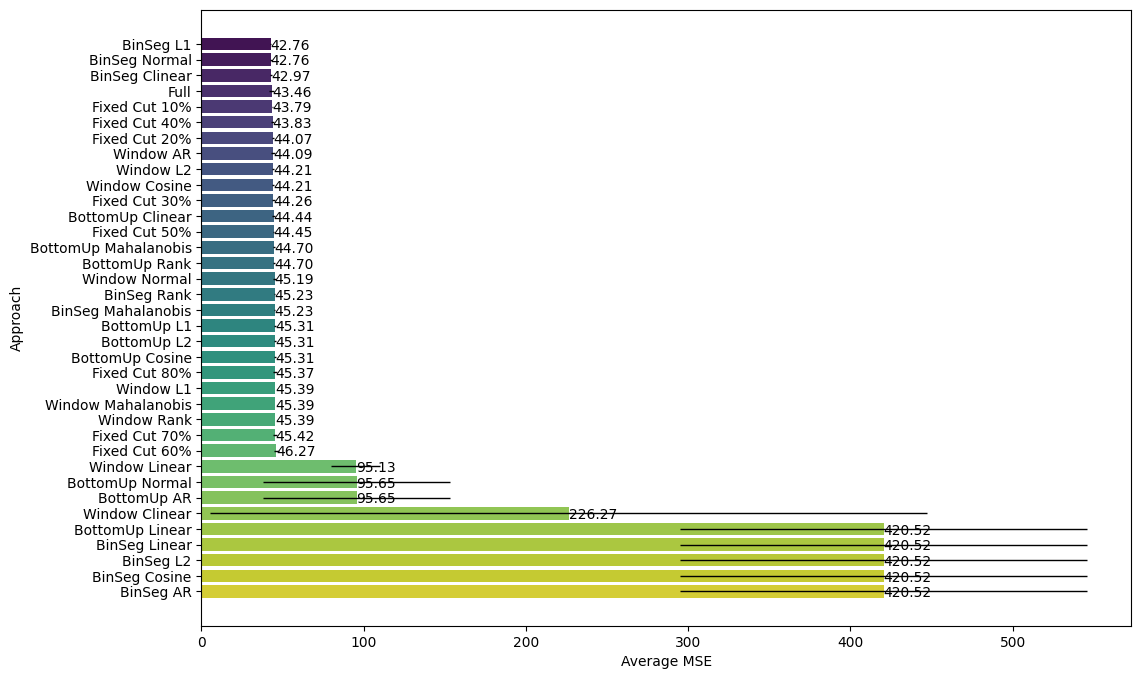

In [18]:
plot_metrics(
    inmet_ibirite_mg, 'Avg_MSE', 'cut_point_approach',
    x_label='Average MSE',
    y_label='Approach',
    dataset_name=inmet_ibirite_mg_name,
    show_title=False,
    pdf_filename='inmet_ibirite_mse.pdf'
)

Saved plot to plots/inmet_ibirite_tduration.pdf


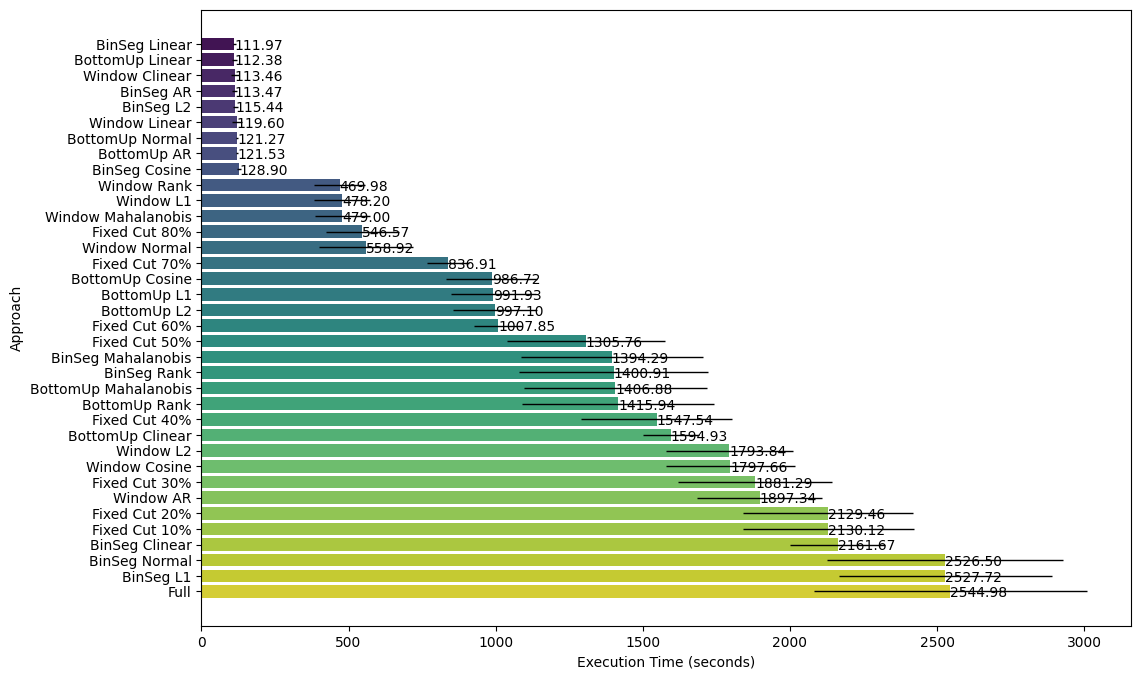

In [19]:
plot_metrics(
    inmet_ibirite_mg, 'total_duration', 'cut_point_approach',
    x_label='Execution Time (seconds)',
    y_label='Approach',
    dataset_name=inmet_ibirite_mg_name,
    show_title=False,
    pdf_filename='inmet_ibirite_tduration.pdf'
)

# [UCI] AIR_QUALITY

In [20]:
uci_air_quality = get_df_for_dataset('UCI', 'AIR_QUALITY')
uci_air_quality_name = 'UCI AIR_QUALITY'
datasets.append((uci_air_quality, uci_air_quality_name))

Saved plot to plots/uci_air_quality_mae.pdf


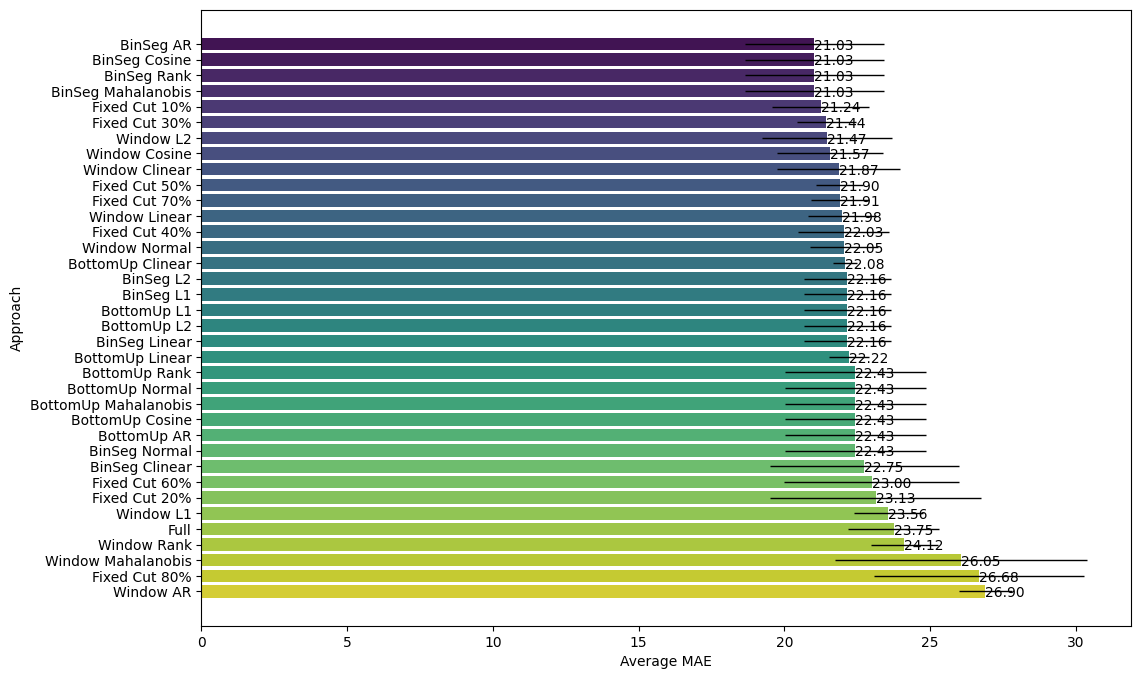

In [21]:
plot_metrics(
    uci_air_quality, 'Avg_MAE', 'cut_point_approach',
    x_label='Average MAE',
    y_label='Approach',
    dataset_name=uci_air_quality_name,
    show_title=False,
    pdf_filename='uci_air_quality_mae.pdf'
)

Saved plot to plots/uci_air_quality_mse.pdf


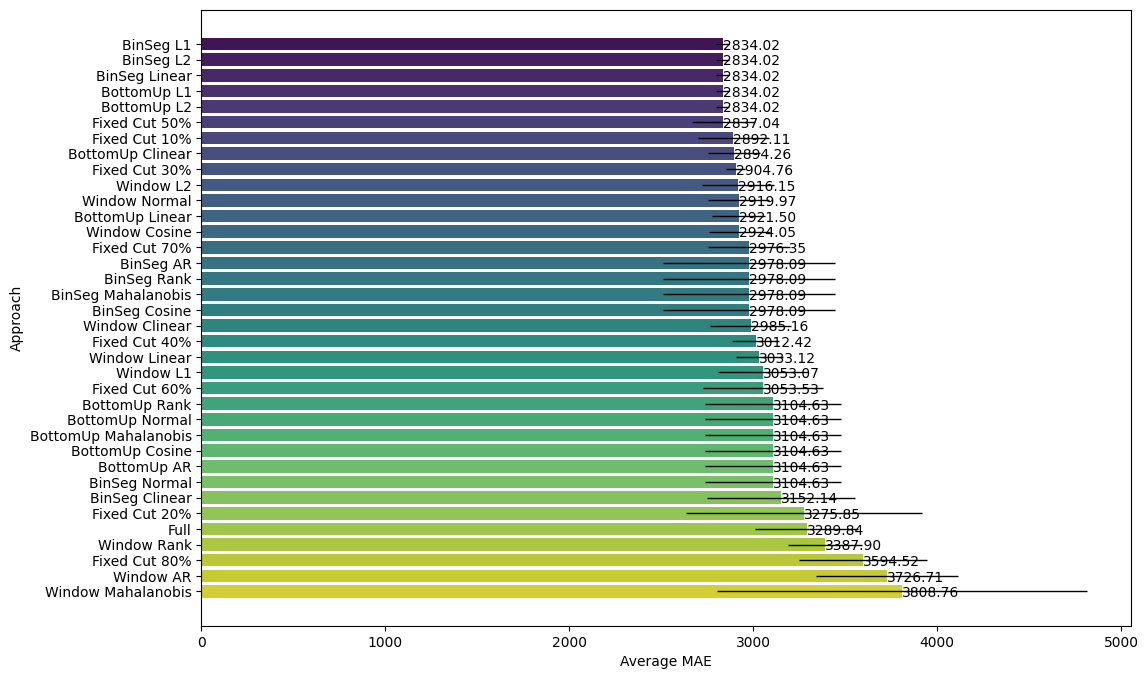

In [22]:
plot_metrics(
    uci_air_quality, 'Avg_MSE', 'cut_point_approach',
    x_label='Average MAE',
    y_label='Approach',
    dataset_name=uci_air_quality_name,
    show_title=False,
    pdf_filename='uci_air_quality_mse.pdf'
)

Saved plot to plots/uci_air_quality_tduration.pdf


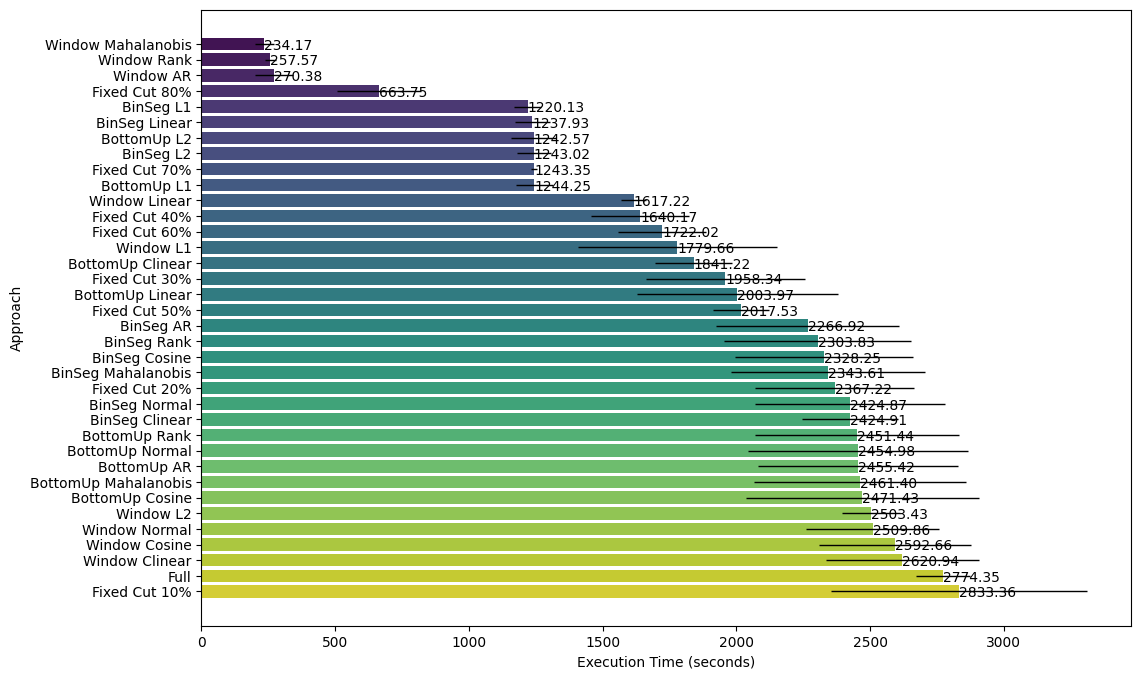

In [23]:
plot_metrics(
    uci_air_quality, 'total_duration', 'cut_point_approach',
    x_label='Execution Time (seconds)',
    y_label='Approach',
    dataset_name=uci_air_quality_name,
    show_title=False,
    pdf_filename='uci_air_quality_tduration.pdf'
)

# [UCI] PRSA_BEIJING

In [24]:
uci_prsa_beijing = get_df_for_dataset('UCI', 'PRSA_BEIJING')
uci_prsa_beijing_name = 'UCI PRSA_BEIJING'
datasets.append((uci_prsa_beijing, uci_prsa_beijing_name))

Saved plot to plots/uci_prsa_beijing_mae.pdf


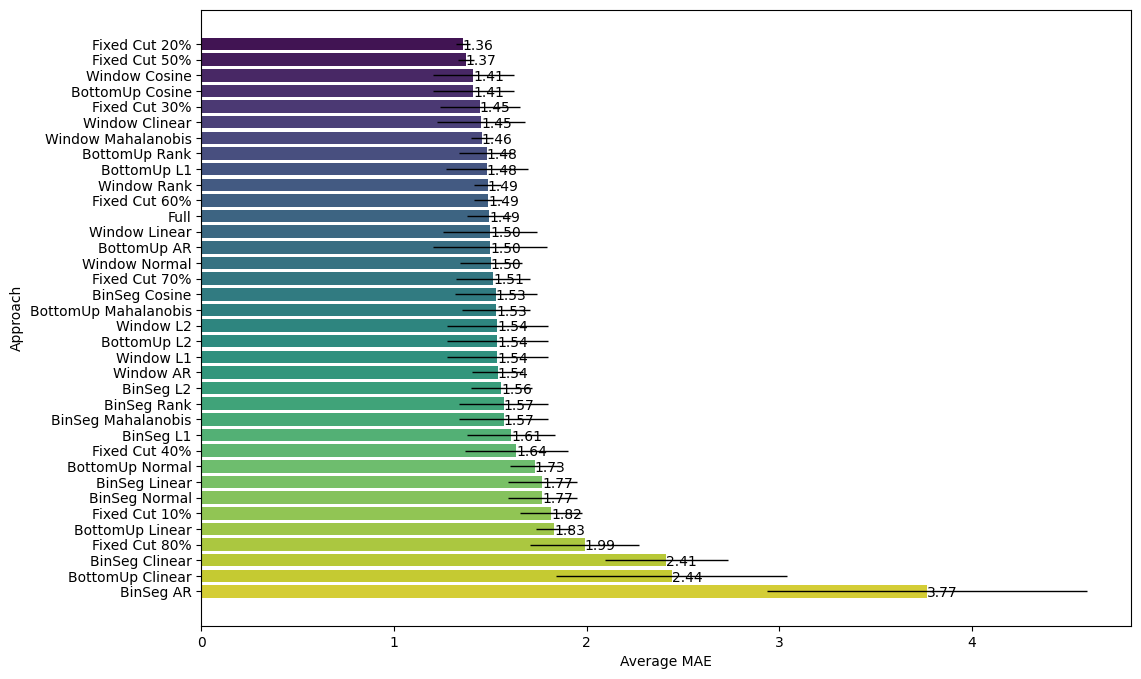

In [25]:
plot_metrics(
    uci_prsa_beijing, 'Avg_MAE', 'cut_point_approach',
    x_label='Average MAE',
    y_label='Approach',
    dataset_name=uci_prsa_beijing_name,
    show_title=False,
    pdf_filename='uci_prsa_beijing_mae.pdf'
)

Saved plot to plots/uci_prsa_beijing_mse.pdf


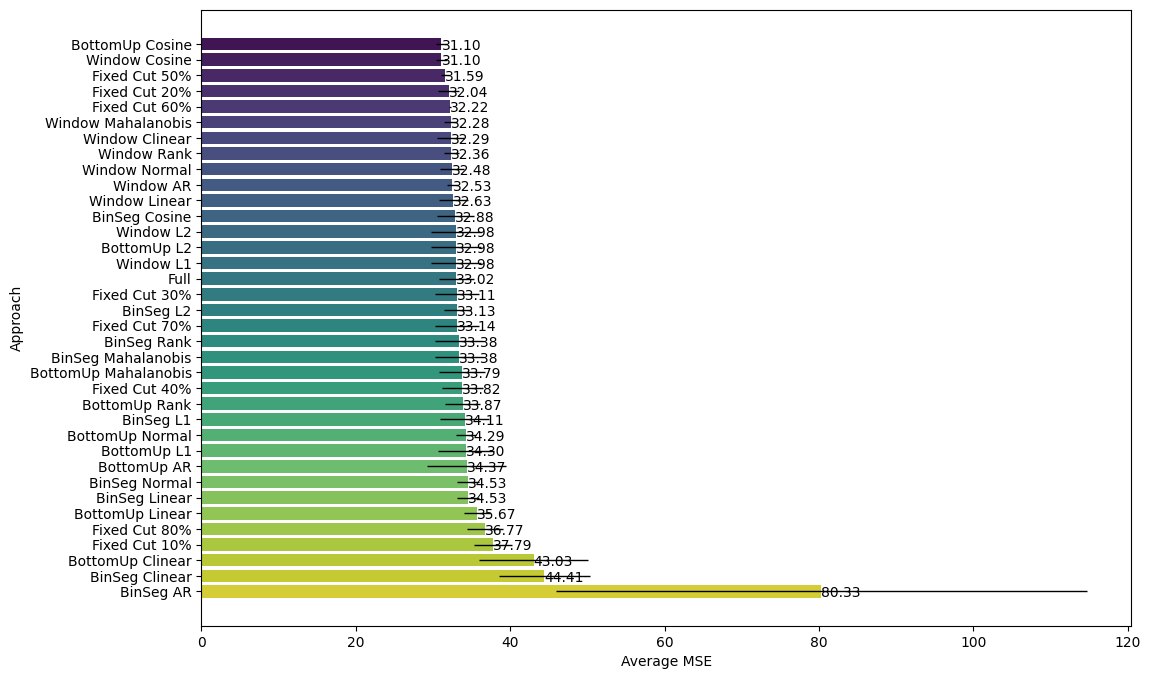

In [26]:
plot_metrics(
    uci_prsa_beijing, 'Avg_MSE', 'cut_point_approach',
    x_label='Average MSE',
    y_label='Approach',
    dataset_name=uci_prsa_beijing_name,
    show_title=False,
    pdf_filename='uci_prsa_beijing_mse.pdf'
)

Saved plot to plots/uci_prsa_beijing_tduration.pdf


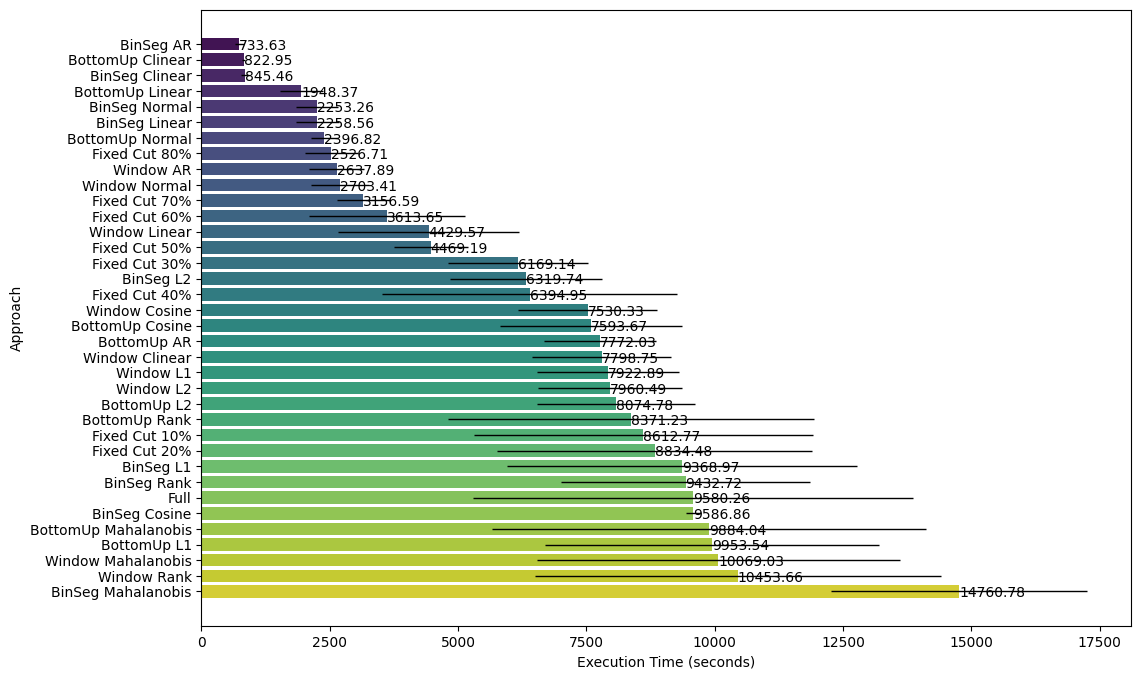

In [27]:
plot_metrics(
    uci_prsa_beijing, 'total_duration', 'cut_point_approach',
    x_label='Execution Time (seconds)',
    y_label='Approach',
    dataset_name=uci_prsa_beijing_name,
    show_title=False,
    pdf_filename='uci_prsa_beijing_tduration.pdf'
)

# Rank

In [28]:
def rank_for_metric(datasets: List, metric: str, ascending: bool = True, drop_approaches: List = []) -> pd.DataFrame:
    drop_approaches = [f'Fixed Cut {i * 10:.0f}%' for i in range(1, 9)]
    approaches = datasets[0][0].index.get_level_values('cut_point_approach').unique().tolist()
    approaches = [approach for approach in approaches if approach not in drop_approaches]
    
    rank_df = pd.DataFrame()

    if not metric.endswith('_mean'):
        metric = f"{metric}_mean"

    for approach in approaches:
        approach_row = {'index': approach}
        
        for dataset, dataset_name in datasets:
            metric_values = dataset.loc[dataset.index.get_level_values('cut_point_approach') == approach, metric]
            approach_row[dataset_name] = metric_values.mean()  # Calculate mean or another relevant statistic

        rank_df = pd.concat([rank_df, pd.DataFrame([approach_row])], ignore_index=True)

    rank_df = rank_df.set_index('index')

    ranked_cols = []

    for col in rank_df.columns:
        rank_df[f"Rank_{col}"] = rank_df[col].rank(ascending=ascending, method='min').astype('int')
        ranked_cols.append(f"Rank_{col}")

    rank_df = rank_df.filter(like='Rank')
    rank_df['Sum'] = rank_df.sum(axis=1)
    rank_df['Rank_Sum'] = rank_df['Sum'].rank(ascending=ascending, method='min').astype('int')
    rank_df = rank_df.sort_values(by='Rank_Sum', ascending=ascending)

    return rank_df

In [29]:
rank_for_metric(datasets, 'Avg_MAE')

,Rank_INMET BRASILIA_DF,Rank_INMET CRISTALINA_GO,Rank_INMET IBIRITE_MG,Rank_UCI AIR_QUALITY,Rank_UCI PRSA_BEIJING,Sum,Rank_Sum
index,,,,,,,
BottomUp Rank,1,18,1,17,5,42,1
Window Clinear,10,9,23,7,3,52,2
Window Linear,3,11,22,8,9,53,3
BinSeg Mahalanobis,4,25,6,1,19,55,4
BinSeg Rank,4,25,6,1,19,55,4
Full,9,6,8,25,8,56,6
Window Cosine,25,15,10,6,1,57,7
BottomUp Cosine,18,4,17,17,1,57,7
BinSeg Cosine,21,1,24,1,12,59,9


In [30]:
rank_for_metric(datasets, 'Avg_MSE')

,Rank_INMET BRASILIA_DF,Rank_INMET CRISTALINA_GO,Rank_INMET IBIRITE_MG,Rank_UCI AIR_QUALITY,Rank_UCI PRSA_BEIJING,Sum,Rank_Sum
index,,,,,,,
Window Linear,6,1,20,16,8,51,1
BottomUp L2,18,9,14,1,10,52,2
Window Normal,13,15,11,8,6,53,3
Window Cosine,25,12,6,10,1,54,4
Full,4,14,4,25,13,60,5
Window L2,25,12,6,7,10,60,5
BottomUp Cosine,18,9,14,18,1,60,5
Window AR,15,7,5,27,7,61,8
BinSeg L2,21,2,24,1,14,62,9


In [31]:
rank_for_metric(datasets, 'total_duration')

,Rank_INMET BRASILIA_DF,Rank_INMET CRISTALINA_GO,Rank_INMET IBIRITE_MG,Rank_UCI AIR_QUALITY,Rank_UCI PRSA_BEIJING,Sum,Rank_Sum
index,,,,,,,
BinSeg Linear,18,3,1,5,6,33,1
BinSeg AR,7,16,4,13,1,41,2
BottomUp Linear,20,5,2,12,4,43,3
BinSeg L2,5,19,5,7,11,47,4
Window L1,3,11,11,10,16,51,5
BottomUp Normal,17,1,7,20,7,52,6
BottomUp Clinear,1,23,21,11,2,58,7
Window Mahalanobis,15,6,12,1,26,60,8
BinSeg L1,6,7,27,4,20,64,9
